In [31]:
#Imports
import pandas as pd
import os
import tensorflow as tf
from tslearn.clustering import TimeSeriesKMeans
from keras import backend as K
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import davies_bouldin_score, silhouette_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from dtaidistance import dtw

### Get data

In [32]:
#Get data 
cwd = os.path.normpath(os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))))
df = pd.read_csv(cwd+'/data/3final_data/Final_Grossload_dataset.csv', index_col='Date') #df = pd.read_csv('user5.csv')
df.index = pd.to_datetime(df.index)
#df = df[['User5', 'temp', 'rhum']]
df.fillna(0, inplace=True)
df.head(1)

,User1,User2,User3,User4,User5,User6,User7,User8,User9,User10,...,User291_lag_24hrs,User292_lag_24hrs,User293_lag_24hrs,User294_lag_24hrs,User295_lag_24hrs,User296_lag_24hrs,User297_lag_24hrs,User298_lag_24hrs,User299_lag_24hrs,User300_lag_24hrs
Date,,,,,,,,,,,,,,,,,,,,,
2010-07-02,0.111,1.561,0.055,0.09,0.0,0.036,0.13,0.143,0.009,0.056,...,0.405,0.075,0.004,0.163,0.038,0.041,0.12,0.129,0.141,0.097


In [33]:
columns_to_keep = []

for column_name in df.columns:
    if column_name.startswith('User') and column_name[4:].isdigit():
        user_number = int(column_name[4:])
        if 1 <= user_number <= 30:
            columns_to_keep.append(column_name)

filtered_df = df[columns_to_keep]
filtered_df.reset_index(inplace=True)
filtered_df.head(1)

,Date,User1,User2,User3,User4,User5,User6,User7,User8,User9,...,User21,User22,User23,User24,User25,User26,User27,User28,User29,User30
0,2010-07-02,0.111,1.561,0.055,0.09,0.0,0.036,0.13,0.143,0.009,...,0.237,0.081,0.072,0.182,0.088,1.713,0.864,0.088,0.126,0.022


### Clustering

C:\Users\rs1044\AppData\Local\Temp\ipykernel_4668\3663830711.py:11: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


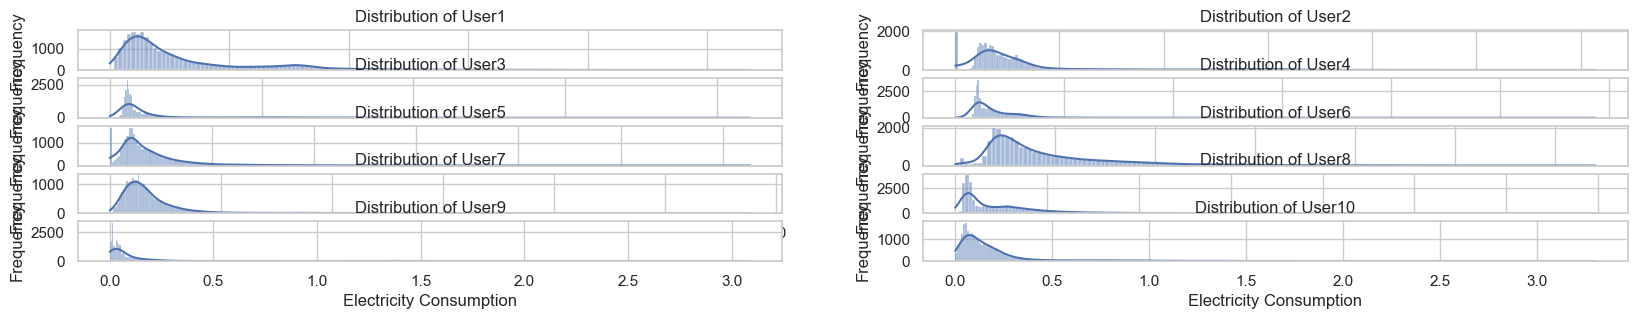

In [4]:
users_data = filtered_df.iloc[:, 1:11]

sns.set(style="whitegrid")
fig, axes = plt.subplots(5, 2, figsize=(20, 3))  # Adjust the size as needed
axes = axes.flatten()
for i, user in enumerate(users_data.columns):
    sns.histplot(users_data[user], ax=axes[i], kde=True)
    axes[i].set_title(f'Distribution of {user}')
    axes[i].set_xlabel('Electricity Consumption')
    axes[i].set_ylabel('Frequency')
plt.tight_layout()
plt.show()

In [5]:
# Additional function to compute DTW Within-Cluster Variance
def compute_dtw_within_cluster_variance(data, labels, centroids):
    clusters_dtw_variance = []
    for cluster_id in set(labels):
        cluster_indices = np.where(labels == cluster_id)[0]
        cluster_data = data[cluster_indices]
        centroid = centroids[cluster_id]
        dtw_distances = [dtw.distance(cluster_data[i], centroid) for i in range(len(cluster_data))]
        clusters_dtw_variance.append(np.mean(dtw_distances))
    return np.mean(clusters_dtw_variance)

In [32]:
metric = "dtw" # "euclidean", "dtw", "softdtw"

#Consider only 1 month, as dtw takes to long otherwise
filtered_df = filtered_df[(filtered_df['Date'].dt.month == 3) & (filtered_df['Date'].dt.year == 2011)]
# Drop date: Focus on Patterns, Not Specific Times / Avoiding Skewed Clusters / Numerical data
data_array = np.array(filtered_df.T.drop('Date').values)
# Scaling - non Gaussian data distributions, no outliers -> use Min-Max not MeanVariance scaling
data_array = MinMaxScaler().fit_transform(data_array)
# Reshape the data array to 2D
data_array_2d = data_array.reshape(data_array.shape[0], -1)

# Specify the maximum number of clusters you want to consider
max_clusters = 20
# Initialize variables to store best parameters
best_cluster_count = 0
best_labels = None
best_db_score = float('inf')  # Davies-Bouldin score
best_silhouette_score = -1    # Silhouette score
best_dtw_variance = float('inf')

# Iterate over possible cluster counts
for cluster_count in range(2, max_clusters + 1):
    kmeans = TimeSeriesKMeans(n_clusters=cluster_count, verbose=False, random_state=42, metric=metric)
    labels = kmeans.fit_predict(data_array)
    centroids = kmeans.cluster_centers_

    # Compute DTW Within-Cluster Variance
    dtw_variance = compute_dtw_within_cluster_variance(data_array, labels, centroids)

    # Evaluate the clustering performance using all scores
    db_score = davies_bouldin_score(data_array, labels)
    sil_score = silhouette_score(data_array, labels)
    print(f"Cluster Count: {cluster_count}, Davies-Bouldin Score: {db_score}, Silhouette Score: {sil_score}, DTW Variance: {dtw_variance}")

    # Update best parameters if the current scores and variance are better
    if db_score < best_db_score and sil_score > best_silhouette_score and dtw_variance < best_dtw_variance:
        best_db_score = db_score
        best_silhouette_score = sil_score
        best_dtw_variance = dtw_variance
        best_cluster_count = cluster_count
        best_labels = labels

# Use the best parameters for final clustering
final_kmeans = TimeSeriesKMeans(n_clusters=best_cluster_count, verbose=False, random_state=42, metric=metric)
final_labels = final_kmeans.fit_predict(data_array)

print("Final labels: ", final_labels)
print("Best cluster count: ", best_cluster_count)
print("Best Davies-Bouldin Score: ", best_db_score)
print("Best Silhouette Score: ", best_silhouette_score)
print("Best DTW Variance: ", best_dtw_variance)

dtw_variance = [3.0044869193855828, 2.5133436056132905, 2.452716918170206,1.854738022617764, 1.8828731296011114, 1.5463779597683391,
                ]

Cluster Count: 2, Davies-Bouldin Score: 1.5629233491106032, Silhouette Score: 0.30112357095295816, DTW Variance: 3.0044869193855828
Cluster Count: 3, Davies-Bouldin Score: 2.0458146352177398, Silhouette Score: 0.055532764232584374, DTW Variance: 2.5133436056132905
Cluster Count: 4, Davies-Bouldin Score: 2.1011029159995536, Silhouette Score: 0.05955310174573076, DTW Variance: 2.452716918170206
Cluster Count: 5, Davies-Bouldin Score: 1.6100277526545335, Silhouette Score: 0.06654205858849845, DTW Variance: 1.854738022617764
Cluster Count: 6, Davies-Bouldin Score: 1.8399877225914063, Silhouette Score: 0.06270759467753095, DTW Variance: 1.8828731296011114
Cluster Count: 7, Davies-Bouldin Score: 1.639530572412653, Silhouette Score: 0.05243488634725047, DTW Variance: 1.5463779597683391
Cluster Count: 8, Davies-Bouldin Score: 1.5225584619201271, Silhouette Score: 0.05589658842309349, DTW Variance: 1.331710178272777
Cluster Count: 9, Davies-Bouldin Score: 1.3794777439213102, Silhouette Score: 0

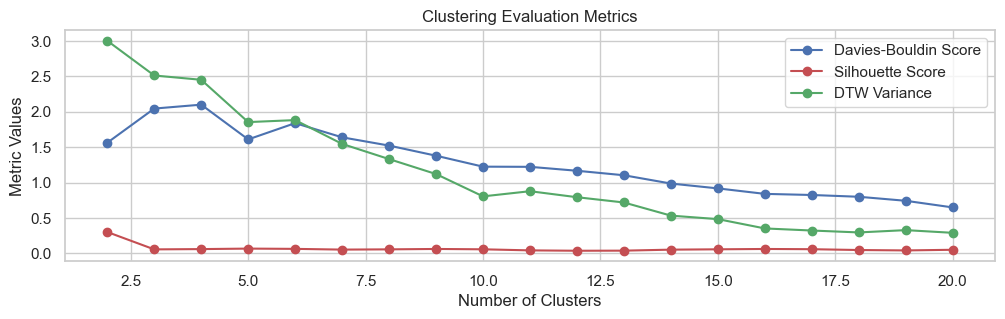

In [34]:

# Cluster counts
cluster_counts = list(range(2, 21))  # From 2 to 20

# Davies-Bouldin Scores
db_scores = [
    1.5629233491106032, 2.0458146352177398, 2.1011029159995536, 1.6100277526545335, 
    1.8399877225914063, 1.639530572412653, 1.5225584619201271, 1.3794777439213102, 
    1.2247549420299495, 1.2223517388788985, 1.1668536542478154, 1.1032850265724974, 
    0.9859995946133934, 0.9175713707135498, 0.8401124275146481, 0.82429730302733, 
    0.7992410148248442, 0.7423042377556635, 0.6485943728411174
]

# Silhouette Scores
silhouette_scores = [
    0.30112357095295816, 0.055532764232584374, 0.05955310174573076, 0.06654205858849845,
    0.06270759467753095, 0.05243488634725047, 0.05589658842309349, 0.061451000758984714,
    0.056604659932835234, 0.041448280641809845, 0.03618190646223289, 0.0375625268808009,
    0.051703024426026416, 0.05653049942114298, 0.06132449721440641, 0.05811407689951662,
    0.04646952964119131, 0.04071121600979724, 0.04995793883968888
]

# DTW Variances
dtw_variances = [
    3.0044869193855828, 2.5133436056132905, 2.452716918170206, 1.854738022617764,
    1.8828731296011114, 1.5463779597683391, 1.331710178272777, 1.120246645765391,
    0.8048297213631208, 0.8778041277916621, 0.7929583804219607, 0.7183457800995275,
    0.5327322895195126, 0.48317070751792884, 0.3515952142426195, 0.32201378412204645,
    0.2951263917685182, 0.3276774372838609, 0.2895763422190159
]

# Plotting
plt.figure(figsize=(12, 3))
plt.plot(cluster_counts, db_scores, marker='o', color='b', label='Davies-Bouldin Score')
plt.plot(cluster_counts, silhouette_scores, marker='o', color='r', label='Silhouette Score')
plt.plot(cluster_counts, dtw_variances, marker='o', color='g', label='DTW Variance')
plt.title('Clustering Evaluation Metrics')
plt.xlabel('Number of Clusters')
plt.ylabel('Metric Values')
plt.legend()
plt.grid(True)
plt.show()

In [35]:
# Use the best parameters for final clustering
best_cluster_count = 10
final_kmeans = TimeSeriesKMeans(n_clusters=best_cluster_count, verbose=False, random_state=42, metric=metric)
final_labels = final_kmeans.fit_predict(data_array)

print("Final labels: ", final_labels)
#np.savetxt('../../3final_data/Clusters_KMeans10_dtw.csv', final_labels, delimiter=",")

Final labels:  [3 5 2 2 6 1 0 7 2 6 6 6 2 0 2 9 8 0 2 2 4 0 0 6 0 6 6 5 0 2]
Best cluster count:  10
Best Davies-Bouldin Score:  1.5629233491106032
Best Silhouette Score:  0.30112357095295816
Best DTW Variance:  3.0044869193855828


# Calculate cluster-wise dtw distances

In [35]:
y = np.loadtxt(f'../../../data/3final_data/Clusters_KMeans10_dtw.csv', delimiter=',').astype(int)
num_clusters = 10
cluster_users = {i: [] for i in range(num_clusters)}

# Iterate through each cluster
for cluster_number in range(num_clusters):
    users_in_cluster = np.where(y == cluster_number)[0] +1
    cluster_users[cluster_number] = users_in_cluster
cluster_users

{0: array([ 7, 14, 18, 22, 23, 25, 29], dtype=int64),
 1: array([6], dtype=int64),
 2: array([ 3,  4,  9, 13, 15, 19, 20, 30], dtype=int64),
 3: array([1], dtype=int64),
 4: array([21], dtype=int64),
 5: array([ 2, 28], dtype=int64),
 6: array([ 5, 10, 11, 12, 24, 26, 27], dtype=int64),
 7: array([8], dtype=int64),
 8: array([17], dtype=int64),
 9: array([16], dtype=int64)}

In [36]:
# Load the CSV file
cluster_df = pd.read_csv('../../../data/3final_data/Clusters_KMeans10_dtw.csv', delimiter=",", header=None)

# Set the column name
cluster_df.columns = ['Cluster']
cluster_df['Cluster'] = cluster_df['Cluster'] + 1

# Create an index column named 'User' starting from 1
cluster_df.index = range(1, len(cluster_df) + 1)
cluster_df.index.name = 'User'

# Display the DataFrame
cluster_df

,Cluster
User,
1,4.0
2,6.0
3,3.0
4,3.0
5,7.0
6,2.0
7,1.0
8,8.0
9,3.0


In [22]:
metric = "dtw" # "euclidean", "dtw", "softdtw"

#Consider only 1 month, as dtw takes to long otherwise
filtered_df = filtered_df[(filtered_df['Date'].dt.month == 3) & (filtered_df['Date'].dt.year == 2011)]
# Drop date: Focus on Patterns, Not Specific Times / Avoiding Skewed Clusters / Numerical data
data_array = np.array(filtered_df.T.drop('Date').values)
# Scaling - non Gaussian data distributions, no outliers -> use Min-Max not MeanVariance scaling
data_array = MinMaxScaler().fit_transform(data_array)
# Reshape the data array to 2D
data_array_2d = data_array.reshape(data_array.shape[0], -1)

In [30]:
def compute_dtw_distance_for_clusters(cluster_df, data_array):
    cluster_dtw_distances = {}

    # Iterate through each cluster
    for cluster_id in cluster_df['Cluster'].unique():
        user_indices = cluster_df[cluster_df['Cluster'] == cluster_id].index - 1  # Adjust index if necessary
        cluster_data = data_array[user_indices]
        
        # Calculate centroid of this cluster
        centroid = np.mean(cluster_data, axis=0)

        # Calculate DTW distance for each user in the cluster and get the average
        dtw_distances = [dtw.distance(user_data, centroid) for user_data in cluster_data]
        cluster_dtw_distances[cluster_id] = np.mean(dtw_distances)

    return cluster_dtw_distances

# Calculate DTW distances for each cluster
dtw_distances_per_cluster = compute_dtw_distance_for_clusters(cluster_df, data_array)

# Print DTW distance for each cluster
agg_dtw = 0
for cluster_id, dtw_distance in dtw_distances_per_cluster.items():
    agg_dtw += dtw_distance
    print(f"Cluster {cluster_id}: Average DTW Distance = {dtw_distance.round(2)}")
print("Total: ", agg_dtw, " and mean: ", agg_dtw/10)

Cluster 4.0: Average DTW Distance = 0.0
Cluster 6.0: Average DTW Distance = 2.98
Cluster 3.0: Average DTW Distance = 1.95
Cluster 7.0: Average DTW Distance = 3.27
Cluster 2.0: Average DTW Distance = 0.0
Cluster 1.0: Average DTW Distance = 3.71
Cluster 8.0: Average DTW Distance = 0.0
Cluster 10.0: Average DTW Distance = 0.0
Cluster 9.0: Average DTW Distance = 0.0
Cluster 5.0: Average DTW Distance = 0.0
Total:  11.913392096705316  and mean:  1.1913392096705315
